#### Introduction/Business Problem

In the city of Toronto, if someone is looking to open a coffee shop, where would you recommend that they open it?

#### Data Section

In order to recommend a good place to open a new coffee shop, I will search all venues related with coffee in all postal codes in Toronto, get recommendation data of them, and retrieve number of users who like them from FourSquare. I will select the place of having many number of recommendation and likes, because it means that lots of people come to the place for a cup of coffee.

#### Methodology

First, scraping postal code data in Wiki and getting geolocation in those area

In [1]:
!pip install geocoder
!pip install cssselect
import pandas as pd
import requests
import lxml.html as lh

url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
page = requests.get(url)

#Store the contents of the website under doc
doc = lh.fromstring(page.content)
#Parse data that are stored between <tr>..</tr> of HTML
tr_elements = doc.xpath('//tr')

df = pd.DataFrame(columns = ['Postal Code', 'Borough', 'Neighbor'])
i=0
#For each row, store each first element (header) and an empty list
j = 0
for a in range(0,20) :
  for t in tr_elements[a]:
      i+=1
      name=t.text_content().replace('\n','').replace('/',',')      
      if 'Not' not in name[3:16] :
      
        if name.find('(') < 0 :
          df.loc[j] = [name[0:3], name[3:], name[3:]]
        else:
          df.loc[j] = [name[0:3], name[3:name.find('(')], name[name.find('(')+1:name.find(')')]]        
        j = j + 1

# get geospatial data
df2 = pd.read_csv("http://cocl.us/Geospatial_data")

# Join two data frame
neighborhoods = df.set_index('Postal Code').join(df2.set_index('Postal Code'))


neighborhoods.head()



     |████████████████████████████████| 102kB 2.4MB/s 


,Borough,Neighbor,Latitude,Longitude
Postal Code,,,,
M3A,North York,Parkwoods,43.753259,-79.329656
M4A,North York,Victoria Village,43.725882,-79.315572
M5A,Downtown Toronto,"Regent Park , Harbourfront",43.654260,-79.360636
M6A,North York,"Lawrence Manor , Lawrence Heights",43.718518,-79.464763
M7A,"Queen's Park , Ontario Provincial Government","Queen's Park , Ontario Provincial Government",43.662301,-79.389494


Second, connecting FourSquare API and retreving all venues related with coffee in the areas of Toronto

In [2]:
from pandas.io.json import json_normalize

CLIENT_ID = 'U5AHNKUAJT5DJ2WVCNWY4NYILPROVI1F2ABQZ3RYAJI4QOOJ' # your Foursquare ID
CLIENT_SECRET = 'FJWPPYYFO2ZMFVNKPA4W4TZOGDSEFWK01ESWPNW3J5ZCHBVB' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30

search_query = 'coffee'
radius = 500

i=2
latitude = neighborhoods.iloc[i,2]
longitude = neighborhoods.iloc[i,3]

url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
results = requests.get(url).json()

# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)
dataframe.head()

,id,name,categories,referralId,hasPerk,location.address,location.crossStreet,location.lat,location.lng,location.labeledLatLngs,location.distance,location.cc,location.city,location.state,location.country,location.formattedAddress,location.postalCode
0,53b8466a498e83df908c3f21,Tandem Coffee,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",v-1585138751,False,368 King St E,at Trinity St,43.653559,-79.361809,"[{'label': 'display', 'lat': 43.65355870959944...",122,CA,Toronto,ON,Canada,"[368 King St E (at Trinity St), Toronto ON, Ca...",NaN
1,58bdc3a23ef0f629212f1f70,Arena Coffee Bar,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",v-1585138751,False,15 Tank House Lane,NaN,43.650280,-79.358860,"[{'label': 'display', 'lat': 43.65028, 'lng': ...",465,CA,Toronto,ON,Canada,"[15 Tank House Lane, Toronto ON M5A 3C4, Canada]",M5A 3C4
2,51853a73498e4d97a8b20831,Rooster Coffee,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",v-1585138751,False,343 King St E,btwn Princess & Berkeley St,43.651900,-79.365609,"[{'label': 'display', 'lat': 43.65189965670432...",479,CA,Toronto,ON,Canada,"[343 King St E (btwn Princess & Berkeley St), ...",M5A 1L1
3,4adb58f7f964a520412621e3,Balzac's Coffee,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",v-1585138751,False,1 Trinity Street,at Distillery Ln.,43.649797,-79.359142,"[{'label': 'display', 'lat': 43.64979714147618...",511,CA,Toronto,ON,Canada,"[1 Trinity Street (at Distillery Ln.), Toronto...",M5A 3C4
4,4d9f1825a77d816e4501fa08,Coffee Time,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",v-1585138751,False,142 Parliament St.,Richmond St.,43.654541,-79.364147,"[{'label': 'display', 'lat': 43.65454122520666...",284,CA,Toronto,ON,Canada,"[142 Parliament St. (Richmond St.), Toronto ON...",NaN


Third, getting the number of tips in each coffee shop of this area


In [0]:
dataframe['tip_counts'] = 0

for i in range(0, dataframe.shape[0]) :
  venue_id = dataframe.iloc[i,0]
  url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)

  result = requests.get(url).json()
  try:
      dataframe.iloc[i, 17] = result['response']['venue']['tips']['count']
  except:
      print('This venue has not been rated yet.')





In [4]:
dataframe

,id,name,categories,referralId,hasPerk,location.address,location.crossStreet,location.lat,location.lng,location.labeledLatLngs,location.distance,location.cc,location.city,location.state,location.country,location.formattedAddress,location.postalCode,tip_counts
0,53b8466a498e83df908c3f21,Tandem Coffee,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",v-1585138751,False,368 King St E,at Trinity St,43.653559,-79.361809,"[{'label': 'display', 'lat': 43.65355870959944...",122,CA,Toronto,ON,Canada,"[368 King St E (at Trinity St), Toronto ON, Ca...",NaN,22
1,58bdc3a23ef0f629212f1f70,Arena Coffee Bar,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",v-1585138751,False,15 Tank House Lane,NaN,43.650280,-79.358860,"[{'label': 'display', 'lat': 43.65028, 'lng': ...",465,CA,Toronto,ON,Canada,"[15 Tank House Lane, Toronto ON M5A 3C4, Canada]",M5A 3C4,1
2,51853a73498e4d97a8b20831,Rooster Coffee,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",v-1585138751,False,343 King St E,btwn Princess & Berkeley St,43.651900,-79.365609,"[{'label': 'display', 'lat': 43.65189965670432...",479,CA,Toronto,ON,Canada,"[343 King St E (btwn Princess & Berkeley St), ...",M5A 1L1,71
3,4adb58f7f964a520412621e3,Balzac's Coffee,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",v-1585138751,False,1 Trinity Street,at Distillery Ln.,43.649797,-79.359142,"[{'label': 'display', 'lat': 43.64979714147618...",511,CA,Toronto,ON,Canada,"[1 Trinity Street (at Distillery Ln.), Toronto...",M5A 3C4,97
4,4d9f1825a77d816e4501fa08,Coffee Time,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",v-1585138751,False,142 Parliament St.,Richmond St.,43.654541,-79.364147,"[{'label': 'display', 'lat': 43.65454122520666...",284,CA,Toronto,ON,Canada,"[142 Parliament St. (Richmond St.), Toronto ON...",NaN,0
5,54cb8e59498e14b4a8ab2aba,Coffee Enterprise,"[{'id': '4bf58dd8d48988d125941735', 'name': 'T...",v-1585138751,False,550 Queen Street East,NaN,43.657290,-79.357592,"[{'label': 'display', 'lat': 43.65729010071037...",417,CA,Toronto,ON,Canada,"[550 Queen Street East, Toronto ON, Canada]",NaN,0
6,55fc340d498e3e59b6211dc0,Coffee Mobile - Brand Partners,"[{'id': '4bf58dd8d48988d125941735', 'name': 'T...",v-1585138751,False,550 Queen Street East,River,43.657487,-79.356930,"[{'label': 'display', 'lat': 43.6574868268064,...",467,CA,Toronto,ON,Canada,"[550 Queen Street East (River), Toronto ON, Ca...",NaN,0
7,5047a0b4e4b046ea951ae2bf,Keefaa Coffee,"[{'id': '4bf58dd8d48988d10a941735', 'name': 'E...",v-1585138751,False,NaN,NaN,43.655896,-79.363509,"[{'label': 'display', 'lat': 43.65589621753793...",294,CA,Toronto,ON,Canada,"[Toronto ON, Canada]",NaN,1
8,4f96be7ae4b01de5727ebcff,Ethiopian Keeffaa Forest Coffee,"[{'id': '4bf58dd8d48988d10a941735', 'name': 'E...",v-1585138751,False,368 Queen Street East,NaN,43.655958,-79.363977,"[{'label': 'display', 'lat': 43.65595786436085...",328,CA,Toronto,ON,Canada,"[368 Queen Street East, Toronto ON, Canada]",NaN,3
9,514c9b65e4b08b26d3c8d8c0,Cuppa Coffee Studios,"[{'id': '4bf58dd8d48988d124941735', 'name': 'O...",v-1585138751,False,53 Ontario Street,NaN,43.653544,-79.366518,"[{'label': 'display', 'lat': 43.6535443049727,...",480,CA,Toronto,ON,Canada,"[53 Ontario Street, Toronto ON, Canada]",NaN,0


Then, for each area of all postal codes in Torontn, getting the number of coffee shop and the total number of likes in the area.

In [0]:
coffee_shops_in_all_areas = neighborhoods

In [6]:
coffee_shops_in_all_areas

,Borough,Neighbor,Latitude,Longitude
Postal Code,,,,
M3A,North York,Parkwoods,43.753259,-79.329656
M4A,North York,Victoria Village,43.725882,-79.315572
M5A,Downtown Toronto,"Regent Park , Harbourfront",43.654260,-79.360636
M6A,North York,"Lawrence Manor , Lawrence Heights",43.718518,-79.464763
M7A,"Queen's Park , Ontario Provincial Government","Queen's Park , Ontario Provincial Government",43.662301,-79.389494
...,...,...,...,...
M8X,Etobicoke,"The Kingsway , Montgomery Road , Old Mill North",43.653654,-79.506944
M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
M7Y,East TorontoBusiness reply mail Processing Cen...,Enclave of M4L,43.662744,-79.321558


In [0]:
coffee_shops_in_all_areas['number_of_coffeeshop'] = 0
coffee_shops_in_all_areas['total_number_of_tips'] = 0
coffee_shops_in_all_areas['total_likes'] = 0

for i in range(0, coffee_shops_in_all_areas.shape[0]) :
  latitude = neighborhoods.iloc[i,2]
  longitude = neighborhoods.iloc[i,3]
  
  # getting the number of coffeeshop
  url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
  results = requests.get(url).json()
  venues = results['response']['venues']
  dataframe = json_normalize(venues)
  coffee_shops_in_all_areas.iloc[i,4] = dataframe.shape[0]  

  # getting tip counts and likes for each coffee shop
  #dataframe['tip_counts'] = 0
  #dataframe['likes'] = 0
  total_tip_count = 0
  total_likes = 0

  for j in range(0, dataframe.shape[0]) :
    venue_id = dataframe.iloc[j,0]
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
    result = requests.get(url).json()
    try:
        total_tip_count = total_tip_count + result['response']['venue']['tips']['count']
    except:
        print('This venue has not been rated yet.')
    
    url = 'https://api.foursquare.com/v2/venues/{}/likes?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
    likes_number = requests.get(url).json()
    total_likes = total_likes + likes_number['response']['likes']['count']
  
  coffee_shops_in_all_areas.iloc[i,5] = total_tip_count
  coffee_shops_in_all_areas.iloc[i,6] = total_likes


In [24]:
coffee_shops_in_all_areas

,Borough,Neighbor,Latitude,Longitude,number_of_coffeeshop,total_number_of_tips,total_likes
Postal Code,,,,,,,
M3A,North York,Parkwoods,43.753259,-79.329656,0,0,0
M4A,North York,Victoria Village,43.725882,-79.315572,0,0,0
M5A,Downtown Toronto,"Regent Park , Harbourfront",43.654260,-79.360636,12,0,557
M6A,North York,"Lawrence Manor , Lawrence Heights",43.718518,-79.464763,0,0,0
M7A,"Queen's Park , Ontario Provincial Government","Queen's Park , Ontario Provincial Government",43.662301,-79.389494,14,0,268
...,...,...,...,...,...,...,...
M8X,Etobicoke,"The Kingsway , Montgomery Road , Old Mill North",43.653654,-79.506944,0,0,0
M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,10,0,142
M7Y,East TorontoBusiness reply mail Processing Cen...,Enclave of M4L,43.662744,-79.321558,0,0,0


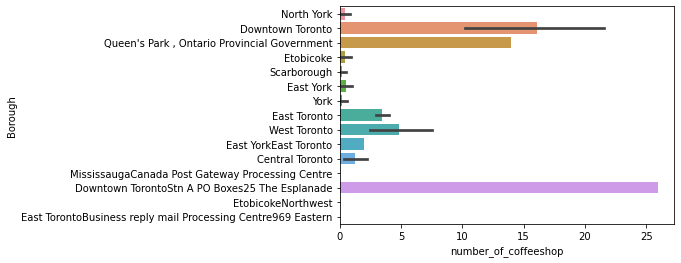

In [9]:
import seaborn as sns
sns.barplot(x='number_of_coffeeshop', y='Borough', data=coffee_shops_in_all_areas)

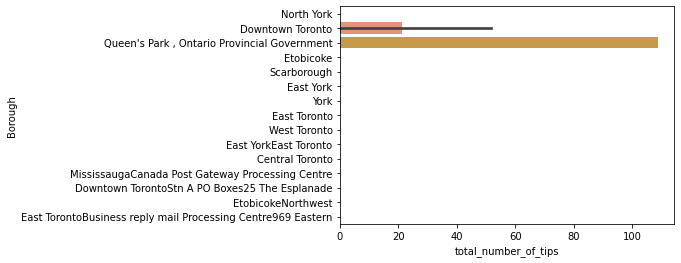

In [10]:
sns.barplot(x='total_number_of_tips', y='Borough', data=coffee_shops_in_all_areas)

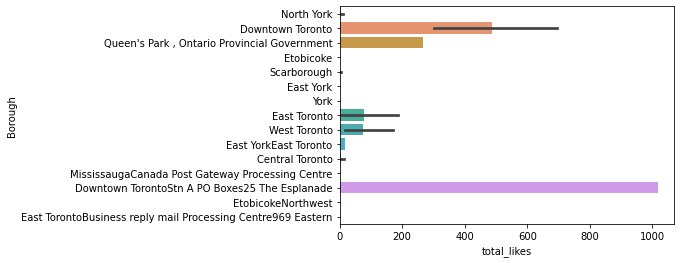

In [25]:
sns.barplot(x='total_likes', y='Borough', data=coffee_shops_in_all_areas)

#### Result

I found that the area that has the highest number of coffeeshop is Downtown Toronto Station The Elplanade, which has also the highest number of likes. Downton Toronto has the second highest number of coffeeshops and likes, and Queen's Park the third. Interesting point is, however, that Queen's park has the highest number of tips in spite that it has smaller number of coffeeshops and likes comparing with Downtown Toronto and Downtown Toronto Station.

```
# 코드로 형식 지정됨
```



#### Discussion

The fact that Queen's park has the highest number of tips in spite that of  smaller number of coffeeshops and likes comparing with Downtown Toronto and Downtown Toronto Station means that many people who are interested in coffee come to Queen's Park, and there would be less competition due to less coffeeshops in same area.

#### Conclusion

Thus I pick up the area of Queen's park, Ontario Provincial Goverment as the recommendation for launching a new coffeeshop.